In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_validate,
    RepeatedKFold,
)

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions_clean__epsg4326.geojson"
)
COMPUTE_G_AUTOCORRELATION = False
RANDOM_STATE=42
N_SPLITS = 5
N_REPEATS = 5

In [3]:
np.random.seed(RANDOM_STATE)

## Loading the spatial tessellation

In [4]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

(155, 21)


Based on [Spatial Regression — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/11_regression.html)

In [5]:
gdf_rome.drop(columns="geometry").head()

,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density,avg_CO_2_per_road,CO_2_alpha,avg_NO_x_per_road,NO_x_alpha,avg_PM_per_road,PM_alpha,avg_VOC_per_road,VOC_alpha
0,10L,Morena,22732.760455,8.947226e+06,10,1.117665,960,107.295822,2.447164,182,2.8,36.9,45.691790,1.379673,0.028145,1.379998,0.000711,1.372780,0.135578,1.360149
1,10A,Don Bosco,8400.069997,2.256348e+06,17,7.534299,1854,821.681815,2.533784,367,93.6,225.9,19.736626,1.506453,0.024918,1.753734,0.000606,1.675556,0.078710,1.261183
2,10B,Appio-Claudio,9265.317994,3.454590e+06,16,4.631520,1236,357.784910,1.465201,239,99.8,86.1,17.311154,1.406042,0.013976,1.272973,0.000557,1.558339,0.067396,1.041726
3,10C,Quarto Miglio,11017.098179,5.030157e+06,9,1.789208,738,146.715093,6.109980,144,35.1,21.7,297.379845,1.387901,0.107992,1.418191,0.001484,1.267525,0.525855,1.523452
4,10D,Pignatelli,5161.962256,9.972986e+05,2,2.005417,178,178.482157,0.000000,50,0.0,66.3,33.474434,1.065894,0.023046,1.000000,0.000804,1.221868,0.103474,1.000000


In [6]:
feature = "car_accidents"

## Linear regression

Based on [Urbana - Urban Data Analysis](https://github.com/egregorimar/urbana)

In [7]:
dependent_variable = feature
independent_variables = ["density_traffic_lights", "density_shops", "perc_roads_bc", "perc_people_far_from_public_transport", "pop_density", "avg_CO_2_per_road"]

In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])

In [9]:
X = gdf_rome_connected[independent_variables]
y = gdf_rome_connected[feature]

## First model

In [10]:
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

### Sensitivity analysis

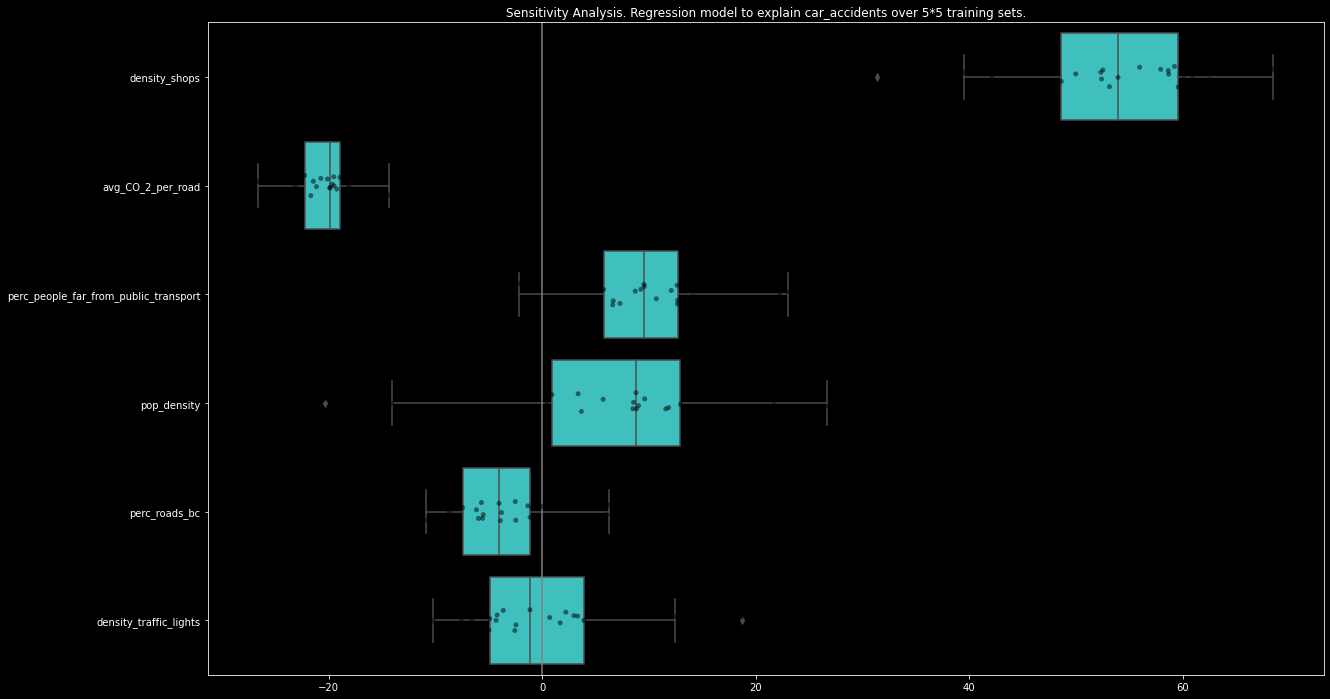

In [11]:
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]


plt.figure(figsize=(20, 2*len(independent_variables)))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title(f"Sensitivity Analysis. Regression model to explain {feature} over {N_SPLITS}*{N_REPEATS} training sets.")

plt.show()

# Watermark

In [12]:
%load_ext watermark
%watermark

Last updated: 2022-03-22T23:37:13.030499+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.4.0-210-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [13]:
%watermark --iversions

numpy     : 1.22.2
seaborn   : 0.11.2
pandas    : 1.4.1
geopandas : 0.10.2
matplotlib: 3.5.1
sys       : 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:42:07) 
[GCC 9.4.0]

